In [1]:
#IMPORTING LIBRARIES
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import coherence
from statsmodels.tsa.stattools import acf
from sklearn.utils import resample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import correlate
from scipy.signal import welch
from scipy.stats import f_oneway
from scipy.stats import linregress
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import euclidean
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy.stats import entropy
from Levenshtein import distance as lcs_distance
from sklearn.model_selection import train_test_split
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from sktime.datasets import load_arrow_head
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, pairwise_distances
from minisom import MiniSom
import matplotlib.pyplot as plt
from tslearn.piecewise import SymbolicAggregateApproximation

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Functions

In [2]:
# DISTANCES
def calculate_correlation(X, Y):
    correlation = np.corrcoef(X, Y)[0, 1]
    return correlation

def calculate_cross_correlation(X, Y):
    cross_corr = correlate(X, Y, mode='same')
    max_corr = np.max(cross_corr)
    return max_corr

def calculate_euclidean_distance(X, Y):
    distance = np.sqrt(np.sum((X - Y)**2))
    return distance

def calculate_dtw_distance(X, Y):
    distance = dtw.distance(X, Y)
    return distance

def calculate_cosine_similarity(X, Y):
    dot_product = np.dot(X, Y)
    magnitude_X = np.sqrt(np.sum(X**2))
    magnitude_Y = np.sqrt(np.sum(Y**2))
    similarity = dot_product / (magnitude_X * magnitude_Y)
    return similarity

def calculate_mutual_information(X, Y):
    return mutual_info_score(X, Y)

def calculate_lcs_distance(X, Y):
    m, n = len(X), len(Y)
    dp = [[0] * (n+1) for _ in range(m+1)]
    for i in range(1, m+1):
        for j in range(1, n+1):
            if X[i-1] == Y[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    lcs_distance = m + n - 2 * dp[m][n]
    return lcs_distance

def calculate_power_spectrum_distance(X, Y):
    _, X_power_spectrum = welch(X, nperseg=min(len(X), 256))
    _, Y_power_spectrum = welch(Y, nperseg=min(len(Y), 256))
    distance = np.sqrt(np.sum((X_power_spectrum - Y_power_spectrum)**2))
    return distance

def test_variance(X, Y):
    statistic, p_value = f_oneway(X, Y)
    return p_value

def calculate_relative_entropy(X,Y):
    '''
    Calculates the relative entropy of the cluster exemplar, Y,
    to the orginal signal, X
    '''
    return entropy(X)/entropy(Y)

def calculate_edit_distance(X, Y, normalized=True):
    return lcs_distance(str(X), str(Y)) / max(len(X), len(Y)) if normalized else lcs_distance(str(X), str(Y))


# HYPOTHESIS TESTS
def autocorrelation_test(X, Y, alpha=0.05):
    """
    Perform autocorrelation test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    acf_X = acf(X, nlags=len(X))
    acf_Y = acf(Y, nlags=len(Y))
    _, p_value = stats.ttest_ind(acf_X, acf_Y)
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The autocorrelation structures of the two time series are significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The autocorrelation structures of the two time series are similar."

import numpy as np
from scipy import stats
from skimage.metrics import structural_similarity

def compute_wss(sequence):
    # Compute the WSS value for the sequence using structural_similarity() function
    reference_sequence = np.zeros_like(sequence)  # Assuming the reference sequence is a zero sequence
    wss_value = structural_similarity(sequence, reference_sequence)
    return wss_value

def wss_test(X,Y,alpha = 0.05 ):
    # Generate example sequences X and Y
    X = np.random.rand(100)
    Y = np.random.rand(100)

    # Compute the WSS values for sequences X and Y
    wss_X = compute_wss(X)
    wss_Y = compute_wss(Y)

    # Perform hypothesis test
    t_statistic, p_value = stats.ttest_ind(wss_X, wss_Y)

    # Compare p-value with significance level
    if p_value < alpha:
        outcome = "Reject the null hypothesis: There is a significant difference in similarity between X and Y."
    else:
        outcome = "Fail to reject the null hypothesis: There is no significant difference in similarity between X and Y."

    return p_value,outcome

def kolmogorov_smirnov_test(X, Y, alpha=0.05):
    """
    Perform Kolmogorov-Smirnov test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    _, p_value = stats.ks_2samp(X, Y)
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The two time series are significantly different based on the Kolmogorov-Smirnov test."
    else:
        return p_value,"Fail to reject the null hypothesis. The two time series are similar based on the Kolmogorov-Smirnov test."

import numpy as np
from scipy import stats

def volatility_test(sequence1, sequence2, alpha=0.05):
    # Compute the volatilities (standard deviations) of the sequences
    volatility1 = np.std(sequence1)
    volatility2 = np.std(sequence2)

    # Perform hypothesis test
    t_statistic, p_value = stats.ttest_ind(sequence1, sequence2, equal_var=False)

    # Compare p-value with significance level
    if p_value < alpha:
        outcome = "Reject the null hypothesis: The volatilities are significantly different."
    else:
        outcome = "Fail to reject the null hypothesis: The volatilities are not significantly different."

    return p_value, outcome

# Example usage
X = np.random.normal(loc=0, scale=1, size=100)
Y = np.random.normal(loc=0, scale=1, size=100)

p_value, result = volatility_test(X, Y)

result_string = f"P-value: {p_value}\n{result}"
print(result_string)


def spectral_coherence_test(X, Y, fs, alpha=0.05):
    """
    Perform spectral coherence test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        fs (float): Sampling frequency of the time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    _, coherence_values = coherence(X, Y, fs=fs)
    test_statistic = np.mean(coherence_values)
    p_value = 1 - stats.chi2.cdf(test_statistic, df=len(coherence_values))
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The spectral coherence of the two time series is significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The spectral coherence of the two time series is similar."


def state_space_modeling_test(X, Y, alpha=0.05):
    """
    Perform state space modeling test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    model_X = SARIMAX(X, order=(1, 0, 0))
    model_Y = SARIMAX(Y, order=(1, 0, 0))
    results_X = model_X.fit()
    results_Y = model_Y.fit()
    aic_X = results_X.aic
    aic_Y = results_Y.aic
    _, p_value = stats.ttest_ind(aic_X, aic_Y)
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The state space models of the two time series are significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The state space models of the two time series are similar."



#METRICS
def calculate_silhouette_score(X, labels):
    """
    Calculate the Silhouette score for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Silhouette score.
    """
    return silhouette_score(X, labels)

def calculate_calinski_harabasz_score(X, labels):
    """
    Calculate the Calinski-Harabasz score for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Calinski-Harabasz score.
    """
    return calinski_harabasz_score(X, labels)

def calculate_davies_bouldin_index(X, labels):
    """
    Calculate the Davies-Bouldin index for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Davies-Bouldin index.
    """
    return davies_bouldin_score(X, labels)

def calculate_dunn_index(X, labels):
    """
    Calculate the Dunn Index for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Dunn Index.
    """
    # Calculate inter-cluster distances
    inter_cluster_distances = pairwise_distances(X)
    inter_cluster_distances = np.max(inter_cluster_distances)

    # Calculate intra-cluster distances
    intra_cluster_distances = []
    for cluster_label in np.unique(labels):
        cluster_points = X[labels == cluster_label]
        if len(cluster_points) > 1:
            intra_cluster_distances.append(np.mean(pairwise_distances(cluster_points)))
    
    # Calculate Dunn Index
    dunn_index = np.min(intra_cluster_distances) / inter_cluster_distances

    return dunn_index

def calculate_fit_scores(X,n_range,metric="euclidean",init_algorithm="kmeans++",max_iter=10):
    '''
    Calculate Silhouette score, Calinski-Harabasz score, 
    Davies-Bouldin index and Dunn Index for a range of 
    K-Mediod models in n_range

    Parameters:
        X (array-like): Input data points
        n_range: Tuple of lower and upper limit for k
    '''

    scores = {  'Silhouette score':[],
                'Calinski-Harabasz Score':[],
                'Davies-Bouldin Index':[],
                'Dunn Index':[]
            }
    models=[]
    for n in range(n_range[0],n_range[1]+1):
        model = TimeSeriesKMedoids(
                            n_clusters=n,  # Number of desired centers
                            init_algorithm=init_algorithm,  # Center initialisation technique
                            max_iter=max_iter,  # Maximum number of iterations for refinement on training set
                            metric=metric,  # Distance metric to use
                            random_state=1,
                        )
        # Predict cluster labels for the input time series
        cluster_labels = model.fit_predict(X)

        # Compute evaluation metrics
        scores['Silhouette score'].append(calculate_silhouette_score(X, cluster_labels))
        scores['Calinski-Harabasz Score'].append(calculate_davies_bouldin_index(X, cluster_labels))
        scores['Davies-Bouldin Index'].append(calculate_calinski_harabasz_score(X, cluster_labels))
        scores['Dunn Index'].append(calculate_dunn_index(X,cluster_labels))
        models.append(model)

    return scores,models

def visualize_power_clustering(model,seq_cluster_map,df_with_clusters,fmtd_times):
    fig, axs = plt.subplots(nrows=model.n_clusters,ncols=1,figsize=(12,8),sharex=True)

    #plot all traces from the first cluster

    for x in range(0,model.n_clusters):
        cluster_mask = seq_cluster_map['Sequence'][seq_cluster_map['Cluster Membership'] == x].to_list()
        num_members = df_with_clusters[cluster_mask].shape[1]
        axs[x].plot(df_with_clusters[cluster_mask], alpha=0.4,color='#ADD8E6',label='_nolegend_')
        medoid_ID = 'Medoid-'
        medoid_ID += str(x+1)
        axs[x].plot(df_with_clusters[medoid_ID],color='red',label=medoid_ID)
        axs[x].set_xticks(labels=fmtd_times[4::4],ticks=list(range(0, len(df_with_clusters), 4))[:-1])
        axs[x].tick_params(axis='x', labelrotation=60)
        axs[x].grid(which='major',color='lightgrey')
        axs[x].set_ylabel('P/kW')
        if x==model.n_clusters-1:
            axs[x].set_xlabel('Time')
        axs[x].legend()
        cluster_ID = "Cluster "
        cluster_ID += str(x+1)
        cluster_ID += ", members="
        cluster_ID += str(num_members)
        axs[x].set_title(cluster_ID)

P-value: 0.38211139448126896
Fail to reject the null hypothesis: The volatilities are not significantly different.


# Data Importing and Pre-Processing

In [9]:
#importing real power for january and february
jf_P_df = pd.read_csv('../data/subsequences/jan_and_feb_daily_P.csv',index_col=0)

#converting dataframe into format needed by clustering functions, each array contains observations across variables for the timestep represented by that row.
jf_P_np_arr = jf_P_df.to_numpy().transpose()
jf_P_clust_fmt = jf_P_np_arr[:-1]

#loading dataframe with barycenter averages for P
jf_P_df_with_bcs = pd.read_csv('../data/subsequences/jan_and_feb_bcs_P.csv',index_col=0)
jf_P_bcs = jf_P_df_with_bcs[['Euclidean Barycenter','Median Barycenter','Modal Barycenter',	'DTW Barycenter',	
                    'SDTW Barycenter-G1.0']]
jf_P_bcs_np = jf_P_bcs.to_numpy().transpose()
jf_P_bcs_count = jf_P_bcs_np.shape[0]
P_bcs_cols = list(jf_P_bcs)

#importing real power for january and february
jf_Q_df = pd.read_csv('../data/subsequences/jan_and_feb_daily_Q.csv',index_col=0)

#converting dataframe into format needed by clustering functions, each array contains observations across variables for the timestep represented by that row.
jf_Q_np_arr = jf_Q_df.to_numpy().transpose()
jf_Q_clust_fmt = jf_Q_np_arr[:-1]

jf_Q_df_with_bcs = pd.read_csv('../data/subsequences/jan_and_feb_bcs_Q.csv',index_col=0)

#loading dataframe with barycenter averages for Q
jf_Q_df_with_bcs = pd.read_csv('../data/subsequences/jan_and_feb_bcs_Q.csv',index_col=0)
jf_Q_bcs = jf_Q_df_with_bcs[['Euclidean Barycenter','Median Barycenter','Modal Barycenter',	'DTW Barycenter',	
                    'SDTW Barycenter-G1.0']]
jf_Q_bcs_np = jf_Q_bcs.to_numpy().transpose()
jf_Q_bcs_count = jf_Q_bcs_np.shape[0]
Q_bcs_cols = list(jf_Q_bcs)


df_times = list(jf_P_df.index)
tstrip = lambda x:x[:-3]
vtstrip = np.vectorize(tstrip)
fmtd_times = vtstrip(df_times)
#fmtd_times

# Fitting K-Medoid Models 

## Checking to see what number of Clusters provide best performance

In [6]:
#P-Data
P_scores,P_models = calculate_fit_scores(jf_P_clust_fmt,(2,7),metric="euclidean",init_algorithm="kmeans++",max_iter=10)
P_scores_df = pd.DataFrame(P_scores)
P_scores_df['k'] = np.arange(2,7+1)
P_scores_df.set_index('k')


,Silhouette score,Calinski-Harabasz Score,Davies-Bouldin Index,Dunn Index
k,,,,
2,0.729709,0.343312,134.229567,0.151278
3,0.589588,0.541213,183.937321,0.120659
4,0.321619,1.017895,141.909748,0.093581
5,0.303619,0.842649,136.183755,0.093211
6,0.278054,0.913773,130.601552,0.093211
7,0.265449,0.889732,117.580950,0.062461


In [19]:
#Q-Data
Q_scores,Q_models = calculate_fit_scores(jf_Q_clust_fmt,(2,7),metric="euclidean",init_algorithm="kmeans++",max_iter=10)
Q_scores_df = pd.DataFrame(Q_scores)
Q_scores_df['k'] = np.arange(2,7+1)
Q_scores_df.set_index('k')

,Silhouette score,Calinski-Harabasz Score,Davies-Bouldin Index,Dunn Index
k,,,,
2,0.677394,0.378937,98.908828,0.137079
3,0.531885,0.611581,121.147541,0.137079
4,0.301946,1.178379,96.083337,0.134362
5,0.250662,1.219065,77.356901,0.092454
6,0.248503,1.052630,70.538567,0.091269
7,0.179656,1.273791,62.032847,0.091269


## Fitting Models to Data based on best scoring k-values

In [11]:
model_P_k_medoids = TimeSeriesKMedoids(
    n_clusters=2,  # Number of desired centers
    init_algorithm="kmeans++",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="euclidean",  # Distance metric to use
    random_state=1,
)

model_P_k_medoids.fit(jf_P_clust_fmt)

model_Q_k_medoids = TimeSeriesKMedoids(
    n_clusters=2,  # Number of desired centers
    init_algorithm="kmeans++",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="euclidean",  # Distance metric to use
    random_state=1,
)

model_Q_k_medoids.fit(jf_Q_clust_fmt)

TimeSeriesKMedoids(init_algorithm='kmeans++', max_iter=10, metric='euclidean',
                   n_clusters=2, random_state=1)

In [12]:
#assigning exemplars to original dataframe
P_cluster_df = pd.DataFrame(data={'Medoid-1':model_P_k_medoids.cluster_centers_[0][0],
                                'Medoid-2':model_P_k_medoids.cluster_centers_[1][0]})
P_cluster_df.set_index(jf_P_df.index,inplace=True)    
jf_P_df_with_exemplars = pd.concat([jf_P_df,P_cluster_df],axis=1)


#assigning exemplars to original dataframe
Q_cluster_df = pd.DataFrame(data={'Medoid-1':model_Q_k_medoids.cluster_centers_[0][0],
                                'Medoid-2':model_Q_k_medoids.cluster_centers_[1][0]})
Q_cluster_df.set_index(jf_Q_df.index,inplace=True)    
jf_Q_df_with_exemplars = pd.concat([jf_Q_df,Q_cluster_df],axis=1)

## Visualizing K-Partition Exemplars

In [13]:
jf_P_seq_cluster_map = pd.DataFrame(data={'Sequence':np.array(jf_P_df.columns[:-1]),'Cluster Membership':model_P_k_medoids.labels_})
jf_Q_seq_cluster_map = pd.DataFrame(data={'Sequence':np.array(jf_Q_df.columns[:-1]),'Cluster Membership':model_Q_k_medoids.labels_})

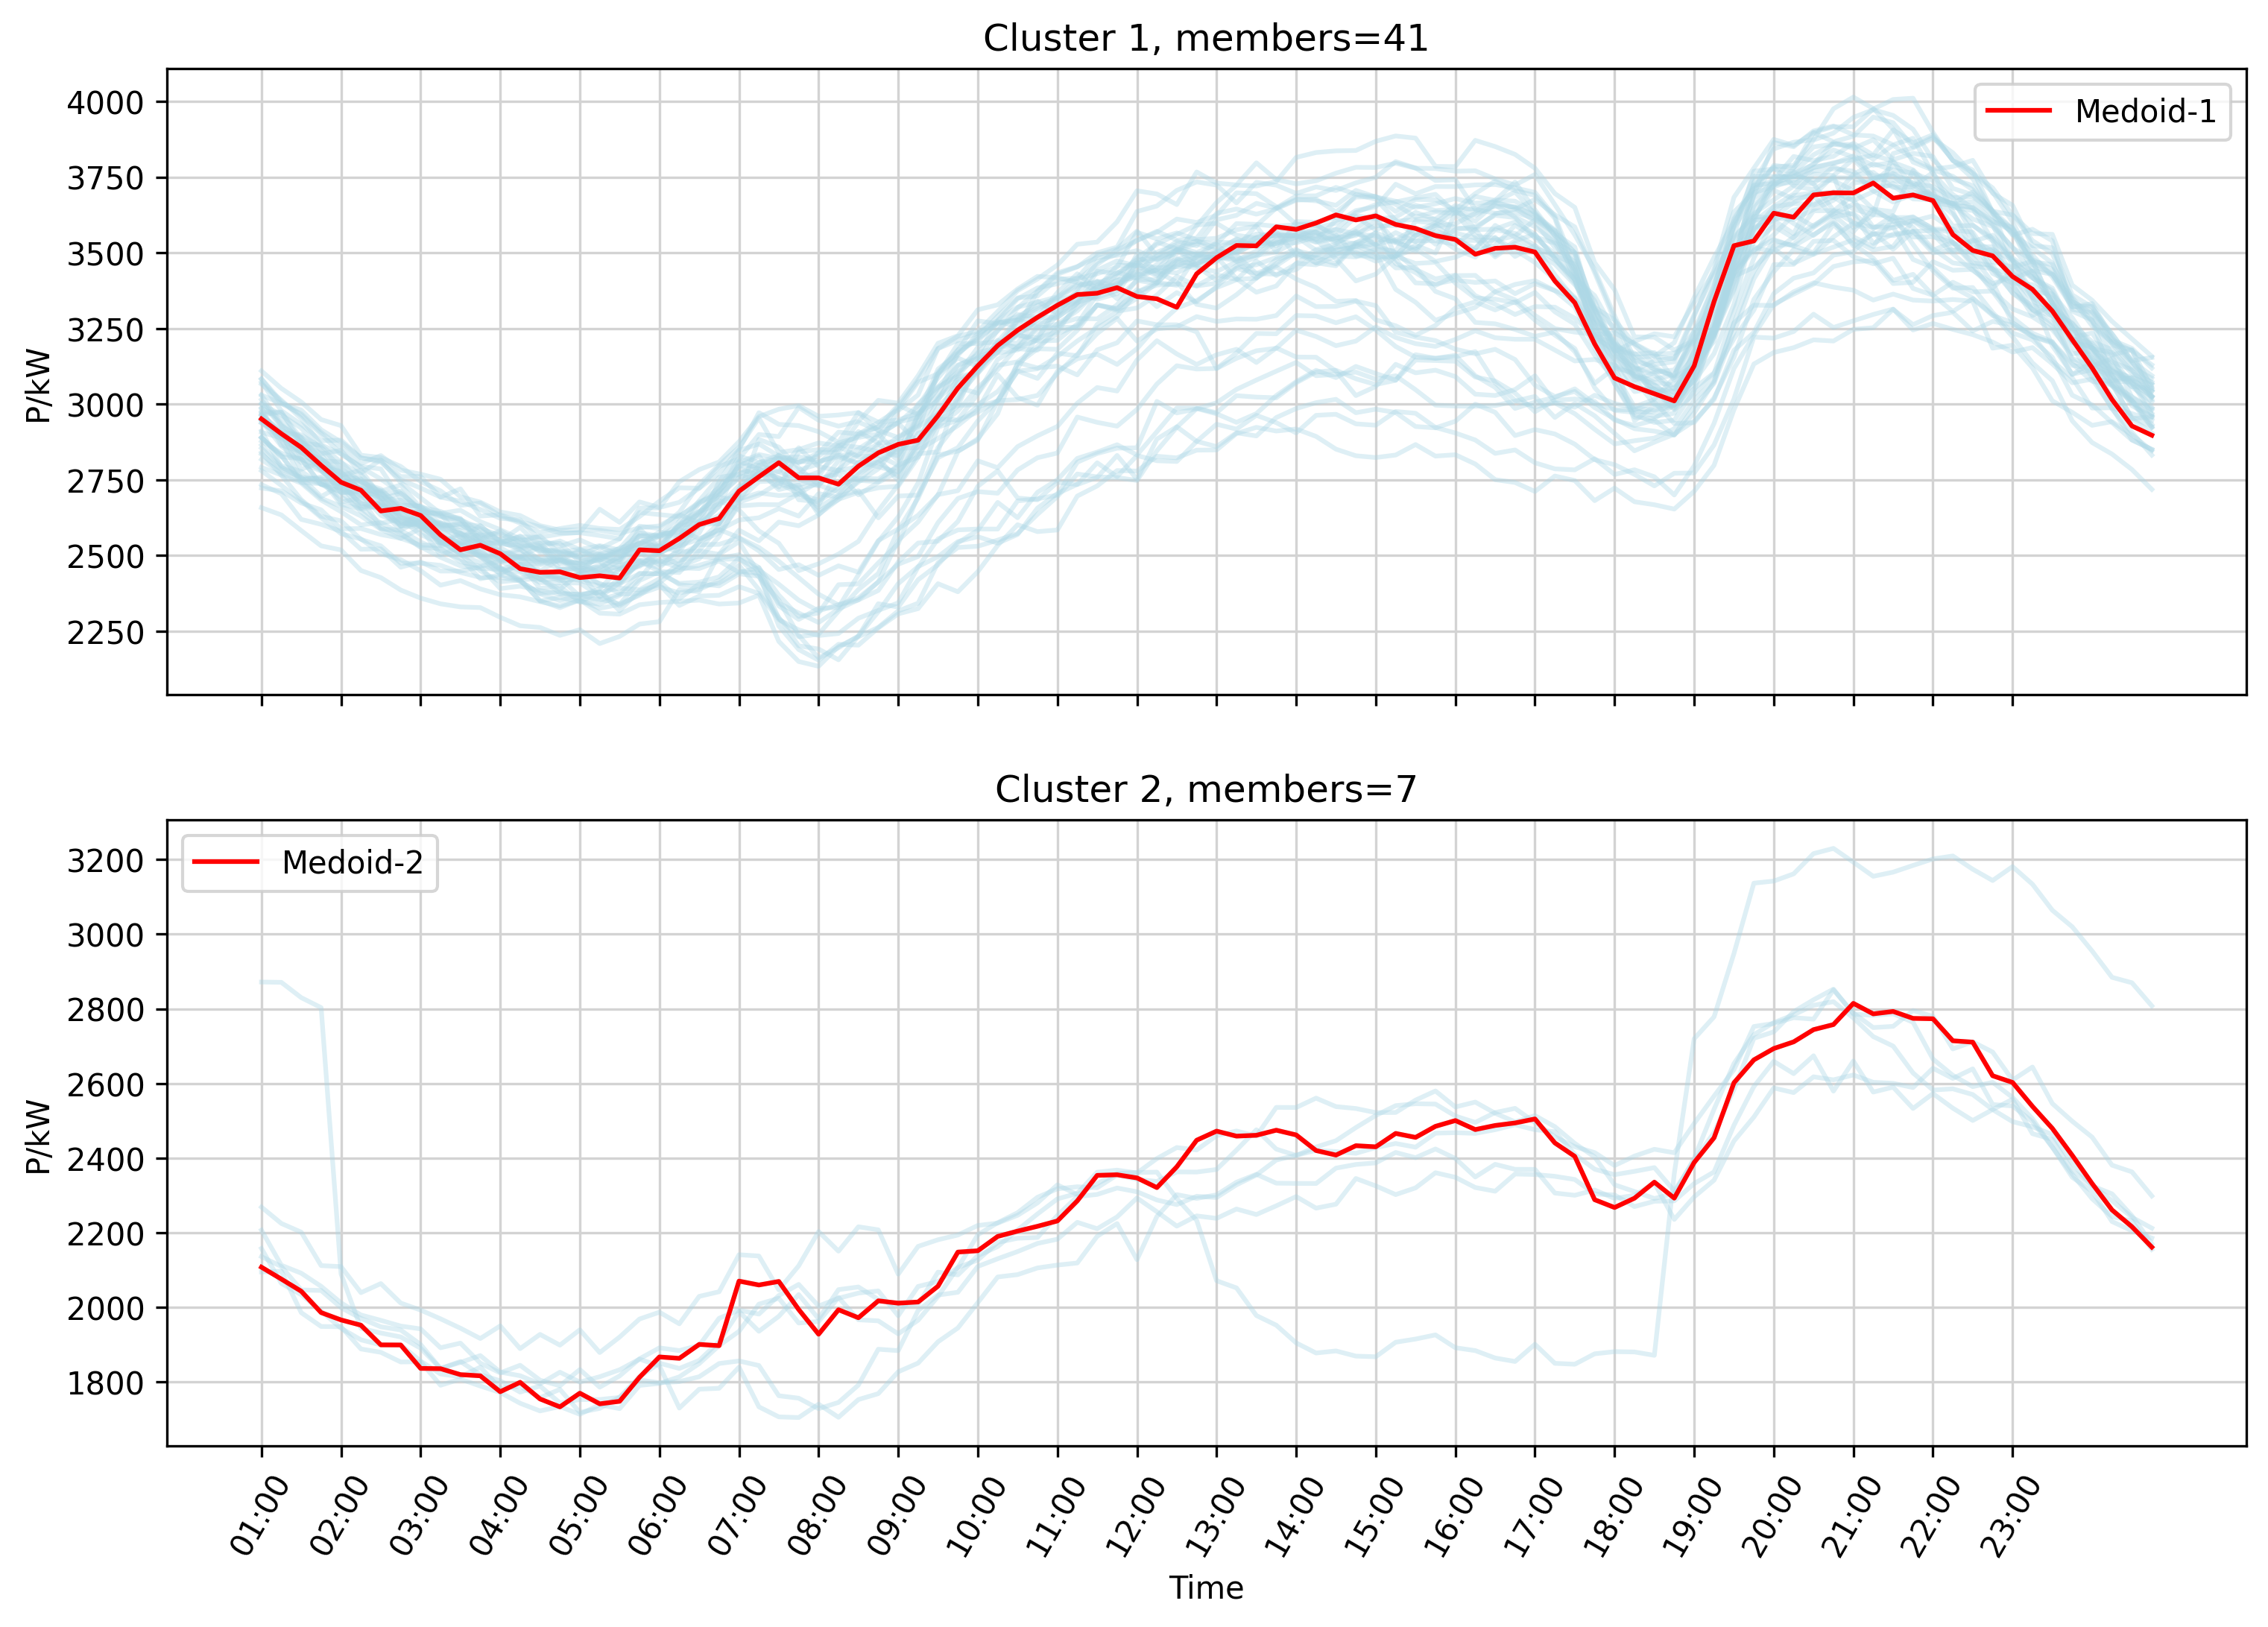

In [19]:
visualize_power_clustering(model_P_k_medoids,jf_P_seq_cluster_map,jf_P_df_with_exemplars,fmtd_times)

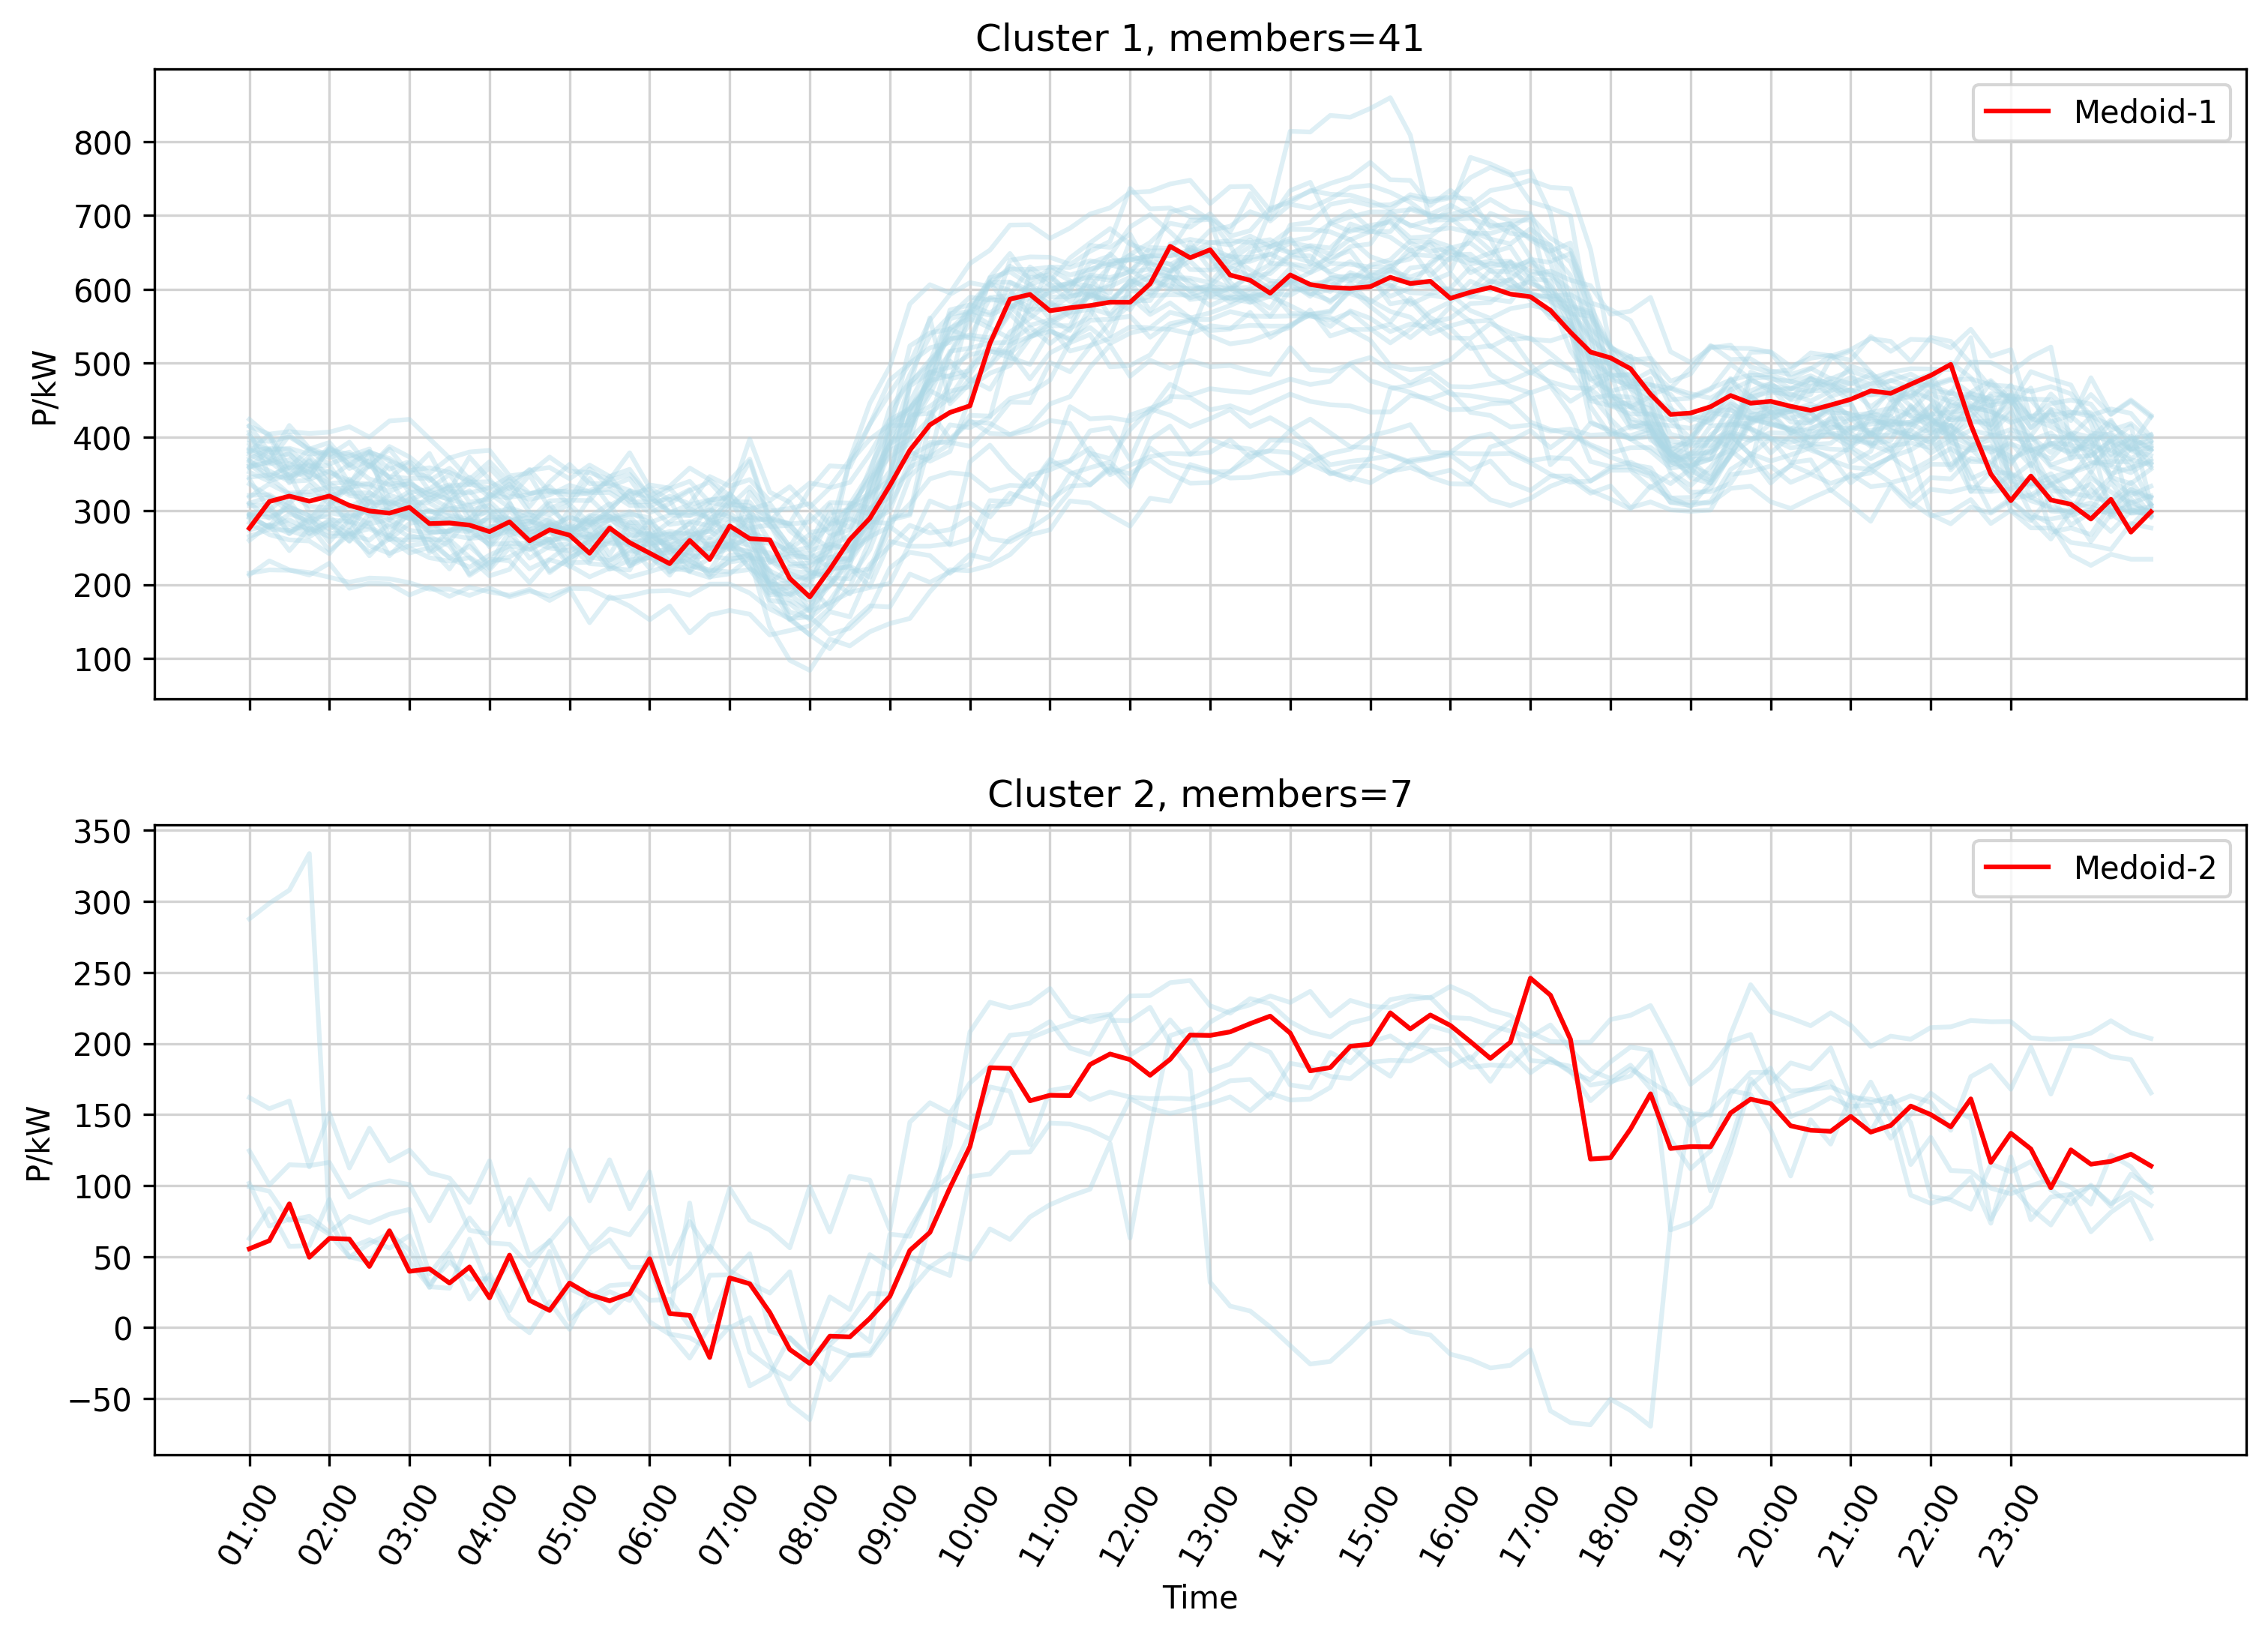

In [14]:
visualize_power_clustering(model_Q_k_medoids,jf_Q_seq_cluster_map,jf_Q_df_with_exemplars,fmtd_times)

# Comparing K-Partition Exemplars to Barycenter Averages

In [ ]:
#P-Data
hypothesis_tests = []
distances = []
pvals = []
model = model_P_k_medoids
X_full = jf_P_bcs
barycenters = X_full
bcs_np =  jf_P_bcs_np
bcs_count = jf_P_bcs_count
Y_cols = list(X_full.columns)   

mapping_ids = {}
mapping_itr = 0
for i in range(0,model.n_clusters):
    X = model.cluster_centers_[i][0]
    for j in range(0,bcs_count):
        tmp = "Exemplar"
        tmp += "_"
        tmp += str(i)
        tmp += "-"
        tmp += Y_cols[j]
        mapping_ids[mapping_itr] =  tmp
        Y = bcs_np[j]
        mem_distances = np.array([
            calculate_correlation(X,Y),
            calculate_cross_correlation(X, Y),
            calculate_euclidean_distance(X, Y),
            calculate_dtw_distance(X, Y),
            calculate_cosine_similarity(X, Y),
            calculate_mutual_information(X, Y),
            calculate_lcs_distance(X, Y),
            calculate_power_spectrum_distance(X, Y),
            test_variance(X, Y),
            calculate_relative_entropy(X,Y),
            calculate_edit_distance(X, Y, normalized=True)
        ])

        act_pval,act_str = autocorrelation_test(X, Y, alpha=0.05)
        wfrmxtst_pval,wfrmxtst_str = wss_test(X, Y, alpha=0.05)
        kstst_pval,kstst_str = kolmogorov_smirnov_test(X, Y, alpha=0.05)
        sptst_pval,sptst_str = spectral_coherence_test(X, Y, 1, alpha=0.05)
        sstst_pval,sstst_str = state_space_modeling_test(X, Y, alpha=0.05)
        mem_hypothesis_tests = np.array([
            act_str,
            wfrmxtst_str,
            kstst_str,
            sptst_str,
            sstst_str
        ])
        mem_hypothesis_tests_pvals = np.array([
            act_pval,
            wfrmxtst_pval,
            kstst_pval,
            sptst_pval,
            sstst_pval
        ])
        
        mapping_itr += 1
        hypothesis_tests.append(mem_hypothesis_tests)
        distances.append(mem_distances)
        pvals.append(mem_hypothesis_tests_pvals)

distance_names = ['Correlation Distance','Cross Correlation Distance',
                    'Euclidean Distance','DTW Distance',
                    'Cosine Similarity Distance','Mutual Information Score',
                    'Longest Common Subsequence Distance' ,'Power Spectrum Distance',
                    'Test Variance','Relative Entropy Distance','Edit Distance']    
hypothesis_names = ['Autocorrelation test','Waveform Structural Similarity Test',
                    'Kolmogorov Smirnov Test','Spectral Coherence Test',
                    'State Space Modelling Test']

hypothesis_df = pd.DataFrame(hypothesis_tests,columns=hypothesis_names)
distances_df = pd.DataFrame(distances,columns=distance_names)
hypothesis_pvals_df = pd.DataFrame(pvals,columns=hypothesis_names)

In [26]:
distances_df

,Correlation Distance,Cross Correlation Distance,Euclidean Distance,DTW Distance,Cosine Similarity Distance,Mutual Information Score,Longest Common Subsequence Distance,Power Spectrum Distance,Test Variance,Relative Entropy Distance,Edit Distance
0,0.981875,9.085410e+08,1837.645618,1216.637551,0.999700,4.564348,192.0,1.909170e+06,3.371345e-03,0.999881,9.302083
1,0.992560,9.496075e+08,610.137600,378.680811,0.999873,4.564348,178.0,7.159594e+05,5.441496e-01,0.999899,4.541667
2,0.990237,9.874531e+08,1114.429113,413.893228,0.999748,4.564348,192.0,1.571323e+06,1.021981e-01,0.999593,5.208333
3,0.875764,8.584106e+08,3737.729014,715.093238,0.998034,4.000884,192.0,4.174279e+06,3.829425e-09,0.999371,9.666667
4,0.872589,8.569509e+08,3789.668084,726.412803,0.997977,4.564348,192.0,4.227479e+06,2.034453e-09,0.999331,9.645833
5,0.982678,6.547407e+08,7006.961188,5023.770075,0.999676,4.564348,192.0,2.648075e+06,5.245032e-32,0.999765,9.916667
6,0.966750,6.840352e+08,8344.878080,6216.550900,0.999411,4.564348,192.0,3.886051e+06,1.292449e-38,0.999783,5.958333
7,0.945378,7.110808e+08,9597.221545,7249.485971,0.998982,4.564348,192.0,2.990776e+06,9.817102e-48,0.999477,6.052083
8,0.880157,6.185624e+08,5638.001245,2901.233445,0.997927,4.000884,192.0,5.998301e+05,5.048663e-27,0.999255,9.885417
9,0.871435,6.174568e+08,5609.802730,2829.466775,0.997783,4.564348,192.0,5.452035e+05,4.340239e-27,0.999215,9.885417


In [29]:
hypothesis_df

,Autocorrelation test,Waveform Structural Similarity Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
1,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
2,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
3,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
4,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
5,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
6,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
7,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
8,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
9,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...


In [27]:
hypothesis_pvals_df

,Autocorrelation test,Waveform Structural Similarity Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,1.0,NaN,7.915729e-05,1.0,NaN
1,1.0,NaN,2.599850e-01,1.0,NaN
2,1.0,NaN,1.922977e-01,1.0,NaN
3,1.0,NaN,6.680318e-10,1.0,NaN
4,1.0,NaN,2.399269e-10,1.0,NaN
5,1.0,NaN,6.029955e-22,1.0,NaN
6,1.0,NaN,8.433125e-26,1.0,NaN
7,1.0,NaN,4.750060e-34,1.0,NaN
8,1.0,NaN,7.077074e-18,1.0,NaN
9,1.0,NaN,7.077074e-18,1.0,NaN


In [15]:
#Q-Data
hypothesis_tests = []
distances = []
pvals = []
model = model_Q_k_medoids
X_full = jf_Q_bcs
barycenters = X_full
bcs_np =  jf_Q_bcs_np
bcs_count = jf_Q_bcs_count
Y_cols = list(X_full.columns)   

mapping_ids = {}
mapping_itr = 0
for i in range(0,model.n_clusters):
    X = model.cluster_centers_[i][0]
    for j in range(0,bcs_count):
        tmp = "Exemplar"
        tmp += "_"
        tmp += str(i)
        tmp += "-"
        tmp += Y_cols[j]
        mapping_ids[mapping_itr] =  tmp
        Y = bcs_np[j]
        mem_distances = np.array([
            calculate_correlation(X,Y),
            calculate_cross_correlation(X, Y),
            calculate_euclidean_distance(X, Y),
            calculate_dtw_distance(X, Y),
            calculate_cosine_similarity(X, Y),
            calculate_mutual_information(X, Y),
            calculate_lcs_distance(X, Y),
            calculate_power_spectrum_distance(X, Y),
            test_variance(X, Y),
            calculate_relative_entropy(X,Y),
            calculate_edit_distance(X, Y, normalized=True)
        ])

        act_pval,act_str = autocorrelation_test(X, Y, alpha=0.05)
        wfrmxtst_pval,wfrmxtst_str = wss_test(X, Y, alpha=0.05)
        kstst_pval,kstst_str = kolmogorov_smirnov_test(X, Y, alpha=0.05)
        sptst_pval,sptst_str = spectral_coherence_test(X, Y, 1, alpha=0.05)
        sstst_pval,sstst_str = state_space_modeling_test(X, Y, alpha=0.05)
        mem_hypothesis_tests = np.array([
            act_str,
            wfrmxtst_str,
            kstst_str,
            sptst_str,
            sstst_str
        ])
        mem_hypothesis_tests_pvals = np.array([
            act_pval,
            wfrmxtst_pval,
            kstst_pval,
            sptst_pval,
            sstst_pval
        ])
        
        mapping_itr += 1
        hypothesis_tests.append(mem_hypothesis_tests)
        distances.append(mem_distances)
        pvals.append(mem_hypothesis_tests_pvals)

distance_names = ['Correlation Distance','Cross Correlation Distance',
                    'Euclidean Distance','DTW Distance',
                    'Cosine Similarity Distance','Mutual Information Score',
                    'Longest Common Subsequence Distance' ,'Power Spectrum Distance',
                    'Test Variance','Relative Entropy Distance','Edit Distance']    
hypothesis_names = ['Autocorrelation test','Waveform Structural Similarity Test',
                    'Kolmogorov Smirnov Test','Spectral Coherence Test',
                    'State Space Modelling Test']

hypothesis_df = pd.DataFrame(hypothesis_tests,columns=hypothesis_names)
distances_df = pd.DataFrame(distances,columns=distance_names)
hypothesis_pvals_df = pd.DataFrame(pvals,columns=hypothesis_names)

/home/shankar/miniconda3/envs/gpu_acc/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_454/3321951709.py:103: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(wss_X, wss_Y)
/home/shankar/miniconda3/envs/gpu_acc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/shankar/miniconda3/envs/gpu_acc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/shankar/mi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71047D+00    |proj g|=  3.78293D-04

At iterate    5    f=  4.70867D+00    |proj g|=  4.05276D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     11      1     0     0   4.053D-06   4.709D+00
  F =   4.7086725165130128     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
/tmp/ipykernel_454/3321951709.py:200: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_value = stats.ttest_ind(aic_X, aic_Y)
/home/shankar/miniconda3/envs/gpu_acc/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_454/3321951709.py:103: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(wss_X, wss_Y)
/home/shankar/miniconda3/envs/gpu_acc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-

In [16]:
distances_df

,Correlation Distance,Cross Correlation Distance,Euclidean Distance,DTW Distance,Cosine Similarity Distance,Mutual Information Score,Longest Common Subsequence Distance,Power Spectrum Distance,Test Variance,Relative Entropy Distance,Edit Distance
0,0.975868,1.649295e+07,651.857211,463.093496,0.997121,4.564348,192.0,6.114496e+05,5.174977e-03,0.997025,8.979167
1,0.977847,1.841062e+07,319.498648,190.316225,0.997736,4.564348,164.0,2.063319e+05,5.900868e-01,0.998271,3.989583
2,0.940875,2.127215e+07,730.085321,486.779618,0.994305,4.564348,192.0,5.798492e+05,1.141238e-02,0.998459,4.989583
3,0.551732,1.243006e+07,1719.586961,335.269835,0.961721,3.292164,192.0,1.232154e+06,1.584789e-13,0.995479,9.302083
4,0.519273,1.224342e+07,1764.250435,356.049363,0.959259,4.564348,192.0,1.295846e+06,3.425101e-14,0.995389,9.114583
5,0.954691,4.865207e+06,2538.806809,2252.356801,0.953761,4.564348,192.0,5.645802e+05,1.965191e-46,-inf,9.156250
6,0.937452,5.438604e+06,2968.372744,2662.924714,0.955705,4.564348,192.0,9.838702e+05,9.619341e-48,-inf,5.458333
7,0.879146,6.256001e+06,3651.089412,3428.914235,0.948188,4.564348,192.0,1.722517e+06,3.659805e-51,-inf,5.406250
8,0.651437,3.616663e+06,1829.997668,1226.272003,0.907347,3.292164,192.0,1.236331e+05,8.865904e-37,-inf,9.468750
9,0.617502,3.552080e+06,1805.652854,1180.575078,0.902413,4.564348,192.0,1.635219e+05,2.332968e-36,-inf,9.281250


In [17]:
hypothesis_df

,Autocorrelation test,Waveform Structural Similarity Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
1,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Fail to reject the null hypothesis. The two ti...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
2,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
3,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
4,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
5,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
6,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
7,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
8,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
9,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis: There is n...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...


In [18]:
hypothesis_pvals_df

,Autocorrelation test,Waveform Structural Similarity Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,1.0,NaN,2.864484e-04,1.0,NaN
1,1.0,NaN,9.852669e-02,1.0,NaN
2,1.0,NaN,1.662751e-03,1.0,NaN
3,1.0,NaN,2.854608e-11,1.0,NaN
4,1.0,NaN,9.449738e-12,1.0,NaN
5,1.0,NaN,9.466267e-45,1.0,NaN
6,1.0,NaN,1.143072e-47,1.0,NaN
7,1.0,NaN,5.540473e-57,1.0,NaN
8,1.0,NaN,9.466267e-45,1.0,NaN
9,1.0,NaN,8.190056e-41,1.0,NaN
